<a href="https://colab.research.google.com/github/ParasJain19/Assignment4-Clustering/blob/main/Assignment4_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

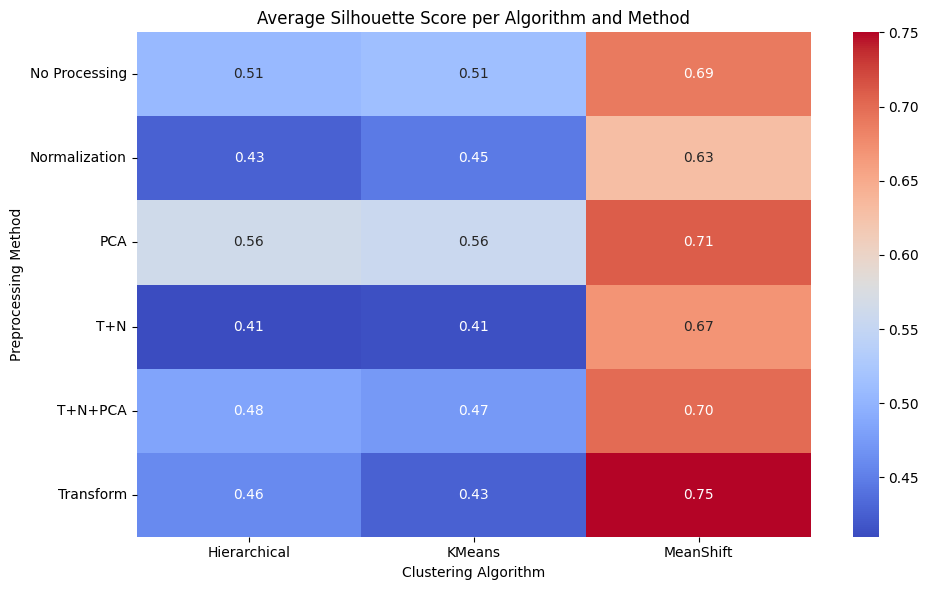

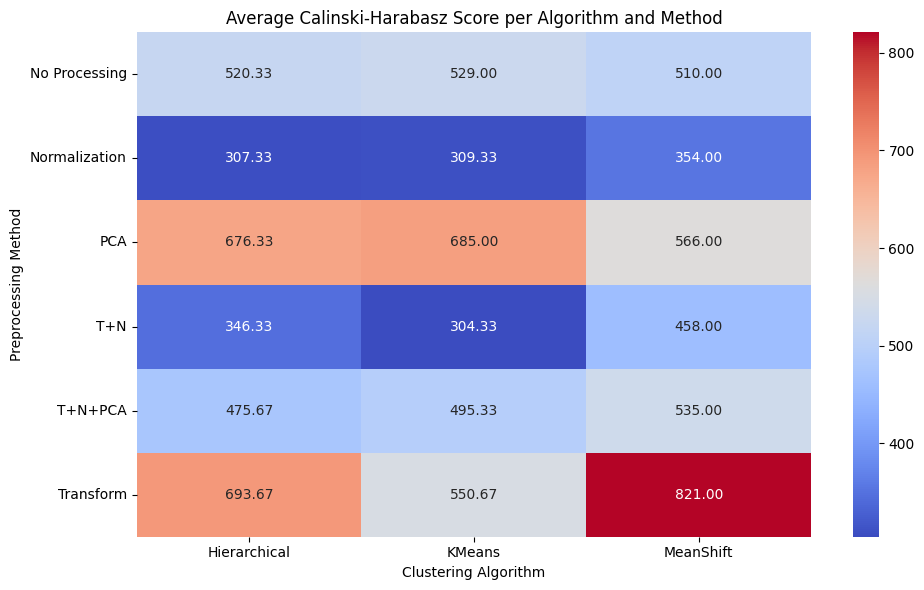

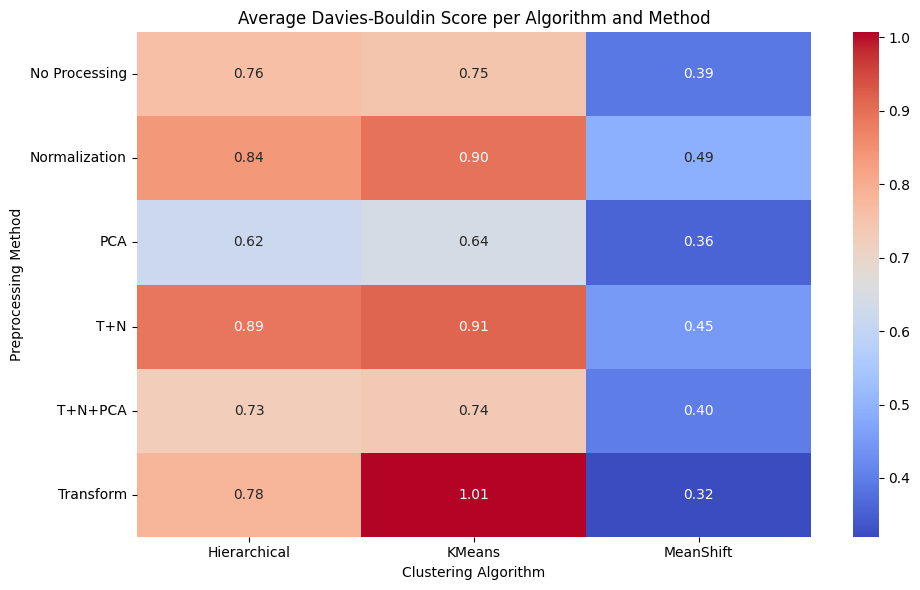

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from warnings import filterwarnings
import matplotlib.pyplot as plt
import seaborn as sns

filterwarnings("ignore")

iris = load_iris()
X_original = pd.DataFrame(iris.data, columns=iris.feature_names)

def no_processing(X): return X.copy()
def normalize(X): return MinMaxScaler().fit_transform(X)
def transform(X): return np.sqrt(np.abs(X))
def apply_pca(X): return PCA(n_components=2).fit_transform(X)
def transform_then_normalize(X): return normalize(transform(X))
def t_n_pca(X): return apply_pca(transform_then_normalize(X))

preprocessing_methods = {
    "No Processing": no_processing,
    "Normalization": normalize,
    "Transform": transform,
    "PCA": lambda X: apply_pca(X),
    "T+N": transform_then_normalize,
    "T+N+PCA": t_n_pca,
}

cluster_range = [3, 4, 5]
results = []

for method_name, preprocess in preprocessing_methods.items():
    try:
        X_proc = preprocess(X_original)
    except Exception as e:
        print(f"[ERROR] Preprocessing failed for {method_name}: {e}")
        continue

    for k in cluster_range:
        try:
            model = KMeans(n_clusters=k, random_state=42, n_init='auto').fit(X_proc)
            labels = model.labels_
            results.append({
                "Algorithm": "KMeans", "Method": method_name, "Clusters": k,
                "Silhouette": round(silhouette_score(X_proc, labels), 2),
                "Calinski-Harabasz": round(calinski_harabasz_score(X_proc, labels)),
                "Davies-Bouldin": round(davies_bouldin_score(X_proc, labels), 2)
            })
        except Exception as e:
            print(f"KMeans failed for {method_name} with k={k}: {e}")

    for k in cluster_range:
        try:
            model = AgglomerativeClustering(n_clusters=k).fit(X_proc)
            labels = model.labels_
            results.append({
                "Algorithm": "Hierarchical", "Method": method_name, "Clusters": k,
                "Silhouette": round(silhouette_score(X_proc, labels), 2),
                "Calinski-Harabasz": round(calinski_harabasz_score(X_proc, labels)),
                "Davies-Bouldin": round(davies_bouldin_score(X_proc, labels), 2)
            })
        except Exception as e:
            print(f"Hierarchical failed for {method_name} with k={k}: {e}")

    try:
        model = MeanShift().fit(X_proc)
        labels = model.labels_
        results.append({
            "Algorithm": "MeanShift", "Method": method_name,
            "Clusters": len(np.unique(labels)),
            "Silhouette": round(silhouette_score(X_proc, labels), 2),
            "Calinski-Harabasz": round(calinski_harabasz_score(X_proc, labels)),
            "Davies-Bouldin": round(davies_bouldin_score(X_proc, labels), 2)
        })
    except Exception as e:
        print(f"MeanShift failed for {method_name}: {e}")

results_df = pd.DataFrame(results)

summary_df = results_df.groupby(['Algorithm', 'Method']).agg({
    'Silhouette': 'mean',
    'Calinski-Harabasz': 'mean',
    'Davies-Bouldin': 'mean'
}).reset_index()

def plot_heatmap(metric):
    plt.figure(figsize=(10, 6))
    heatmap_data = summary_df.pivot(index='Method', columns='Algorithm', values=metric)
    sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Average {metric} Score per Algorithm and Method')
    plt.xlabel("Clustering Algorithm")
    plt.ylabel("Preprocessing Method")
    plt.tight_layout()
    plt.show()

for metric in ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin']:
    plot_heatmap(metric)

results_df.to_csv("clustering_full_results.csv", index=False)
summary_df.to_csv("clustering_summary.csv", index=False)
